In [2]:
import pandas as pd
import numpy as np
import re 
import os
import sys

#Deze staan ook in rdkithelperdinges
# noinspection PyPackageRequirements
import rdkit

# noinspection PyPackageRequirements
import rdkit.Chem.AllChem

# noinspection PyPackageRequirements
import rdkit.Chem.Draw

# noinspection PyPackageRequirements
import rdkit.Chem.rdmolfiles

from rdkit.Chem.rdmolfiles import  MolFromXYZFile
from rdkit.Chem import AllChem

# Load the data and couple the SMILES to the yields and remove nan's

In [3]:
# --- 1. Bestanden inlezen als ruwe tekst ---
yields_path = "data/compounds_yield.csv"
smiles_path = "data/compounds_smiles.csv"

# --- 2. Parser voor yields: hoogste percentage extraheren ---
yield_data = []
with open(yields_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split(" ", 1)
        if len(parts) == 2:
            compound_id, yield_info = parts
            percentages = re.findall(r'(\d+)%', yield_info)
            if percentages:
                max_yield = max(map(int, percentages))
                yield_data.append((compound_id, str(max_yield)))

df_yields_clean = pd.DataFrame(yield_data, columns=["compound_id", "yield"])

# --- 3. Parser voor SMILES ---
smiles_data = []
with open(smiles_path, "r") as f:
    for line in f:
        parts = [p.strip() for p in line.strip().split(",")]
        if len(parts) == 4:
            compound_id, smiles_raw, number, _ = parts  # ignore smiles_normalized
            smiles_data.append((compound_id, smiles_raw, number))

df_smiles_clean = pd.DataFrame(
    smiles_data,
    columns=["compound_id", "smiles_raw", "some_number"]
)

# --- 4. Merge op compound_id ---
df_merged = pd.merge(df_smiles_clean, df_yields_clean, on="compound_id", how="inner")

print("Merged DataFrame:")
print(df_merged)


Merged DataFrame:
   compound_id                                        smiles_raw some_number  \
0        comp1                            C1C2=C(N=C(O2)C)C=CC=1           1   
1        comp2                        C1C2=C(N=C(O2)C)C=C(Br)C=1          11   
2        comp3                            C1C2=C(N=C(N2)C)C=CC=1           2   
3        comp4                          C1(Cl)=CC=NC2NC(C)=CC1=2          10   
4        comp5                        C1C2=C(N=C(O2)C)C=C(OC)C=1           1   
..         ...                                               ...         ...   
78      comp88  C1C=CC=C2N(C(=O)OC(C)(C)C)C=C([Si]([H])(C)C)C=12           1   
79      comp91                                    C1=CC(F)=NC=C1           1   
80      comp92                                    C1=CC(F)=NC=C1           2   
81      comp93                                    C1=CC(F)=NC=C1           7   
82      comp97                           N1=CC=C(C(F)(F)F)C=C1Cl           2   

   yield  
0     68  

Convert the SMILES to Graphs

In [9]:
def smiles_to_rdkit_molecule(smiles_str):
    # Convert SMILES string to RDKit mol object
    mol = rdkit.Chem.MolFromSmiles(smiles_str)
    
    # Add hydrogens to the molecule
    #mol = rdkit.Chem.AddHs(mol)

    AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
    
    return mol

In [5]:
def rdkit_molecule_to_xyz_data (molecule):
   xyz_molecule = rdkit.Chem.MolToXYZBlock(molecule)
   return xyz_molecule

In [6]:
smiles_test="C1C2=C(N=C(O2)C)C=C(Br)C=1"
test1=smiles_to_rdkit_molecule(smiles_test)
print(test1)

test1_xyz=rdkit_molecule_to_xyz_data(test1)
print(test1_xyz)
print(f"type:{type(test1_xyz)}")


17

C     -1.348565   -0.931470   -1.055078
C     -0.150763   -0.424992   -0.563752
C     -0.194279    0.379231    0.563974
N      1.093581    0.705187    0.787817
C      1.899268    0.146782   -0.133745
O      1.104279   -0.526915   -0.929900
C      3.396362    0.270020   -0.229585
C     -1.403466    0.669820    1.184673
C     -2.599512    0.168062    0.699609
Br    -4.270215    0.562652    1.547595
C     -2.547610   -0.638043   -0.432239
H     -1.326795   -1.566886   -1.943858
H      3.831955   -0.632296    0.242218
H      3.712058    0.370150   -1.304639
H      3.686927    1.196234    0.340609
H     -1.410379    1.298647    2.061624
H     -3.472849   -1.046183   -0.835324

type:<class 'str'>


In [11]:
import math
from collections import defaultdict
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

COVALENT_RADII = {
    "H": 0.31, "C": 0.76, "N": 0.71, "O": 0.66, "Br": 1.14,
}

ATOM_NUMBERS = {
    "H": 1, "C": 6, "N": 7, "O": 8, "Br": 35,
}

class MolecularGraph:
    def __init__(self, xyz_string: str):
        self.atoms = []  # (element, x, y, z)
        self.graph = defaultdict(list)
        self._parse_xyz_string(xyz_string)
        self._build_graph()

    def _parse_xyz_string(self, xyz_string: str):
        lines = xyz_string.strip().splitlines()
        atom_lines = lines[2:]  # Skip header

        for line in atom_lines:
            parts = line.split()
            if len(parts) == 4:
                element, x, y, z = parts
                self.atoms.append((element, float(x), float(y), float(z)))

    def _distance(self, a, b):
        _, x1, y1, z1 = a
        _, x2, y2, z2 = b
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

    def _build_graph(self):
        n = len(self.atoms)
        for i in range(n):
            for j in range(i+1, n):
                elem1 = self.atoms[i][0]
                elem2 = self.atoms[j][0]
                if elem1 not in COVALENT_RADII or elem2 not in COVALENT_RADII:
                    continue
                cutoff = 1.2 * (COVALENT_RADII[elem1] + COVALENT_RADII[elem2])
                if self._distance(self.atoms[i], self.atoms[j]) <= cutoff:
                    self.graph[i].append(j)
                    self.graph[j].append(i)

    def to_pyg_data(self) -> Data:
        # Node features: atomic number
        x = torch.tensor([[ATOM_NUMBERS[atom[0]]] for atom in self.atoms], dtype=torch.long)

        # Edge index
        edge_index = []
        for i in self.graph:
            for j in self.graph[i]:
                edge_index.append([i, j])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        # Optional: 3D coordinates
        pos = torch.tensor([coords[1:] for coords in self.atoms], dtype=torch.float)

        return Data(x=x, edge_index=edge_index, pos=pos)

    def visualize(self, with_labels=True, layout="spring"):
        G = nx.Graph()
        for i, atom in enumerate(self.atoms):
            G.add_node(i, label=atom[0])
        for i, neighbors in self.graph.items():
            for j in neighbors:
                if not G.has_edge(i, j):
                    G.add_edge(i, j)

        if layout == "spring":
            pos = nx.spring_layout(G)
        elif layout == "kamada":
            pos = nx.kamada_kawai_layout(G)
        elif layout == "3d":
            pos = {i: atom[1:] for i, atom in enumerate(self.atoms)}
        else:
            raise ValueError("Onbekende layout")

        labels = nx.get_node_attributes(G, 'label')
        nx.draw(G, pos, labels=labels if with_labels else None, with_labels=with_labels,
                node_color='skyblue', node_size=800, font_size=10)
        plt.show()


[16:44:54] Molecule does not have explicit Hs. Consider calling AddHs()


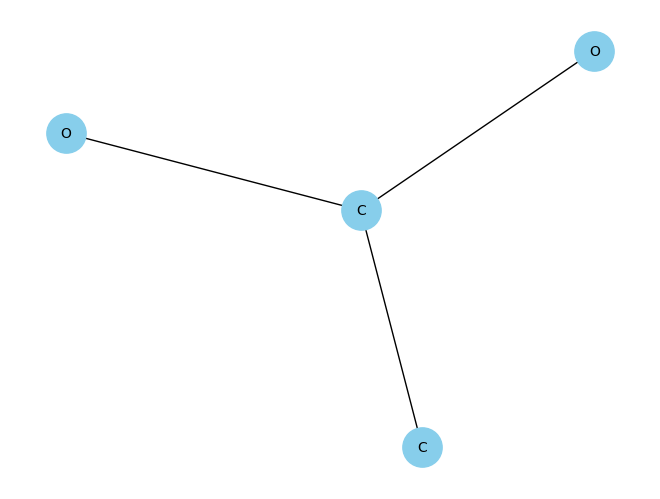

Data(x=[4, 1], edge_index=[2, 6], pos=[4, 3])


In [12]:
mol = smiles_to_rdkit_molecule("CC(=O)O")  # Azijnzuur
xyz_str = rdkit_molecule_to_xyz_data(mol)

g = MolecularGraph(xyz_str)
g.visualize()
pyg_data = g.to_pyg_data()

print(pyg_data)
